# Post-processing of the axes

IDEA:
- take the data of the axes
- smooth it

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.interpolate import UnivariateSpline


In [208]:
VIDEO_NUMBER = "7"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_CSV_PATH = str(PROJECT_ROOT / "notebook" / "spin" / "intermediate_data" / f"Spin_data_{VIDEO_NUMBER}.csv")
INPUT_CENTER_PATH = str(PROJECT_ROOT / "notebook" / "ball_detection" / "intermediate_data" / f"Circle_positions_raw_{VIDEO_NUMBER}.csv")

In [209]:
# Load data
df_spin = pd.read_csv(INPUT_CSV_PATH)
df_center = pd.read_csv(INPUT_CENTER_PATH)

# Convert to numeric
for col in ['pA_x', 'pA_y', 'pB_x', 'pB_y']:
    df_spin[col] = pd.to_numeric(df_spin[col], errors='coerce')

for col in ['x', 'y', 'radius']:
    df_center[col] = pd.to_numeric(df_center[col], errors='coerce')

# Optionally interpolate to avoid dropping frames (recommended)
df_spin[['pA_x', 'pA_y', 'pB_x', 'pB_y']] = df_spin[['pA_x', 'pA_y', 'pB_x', 'pB_y']].interpolate(method='linear')
df_center[['x', 'y', 'radius']] = df_center[['x', 'y', 'radius']].interpolate(method='linear')


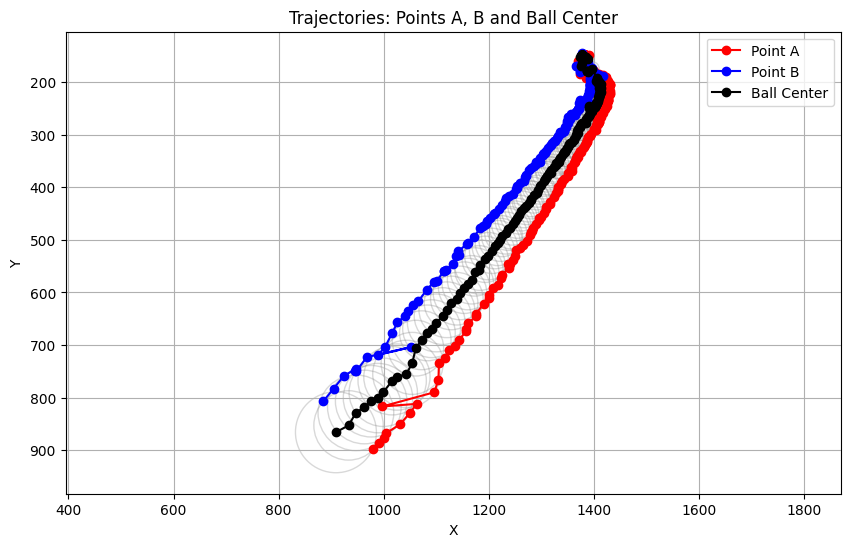

In [210]:
# Visualize all trajectories
plt.figure(figsize=(10, 6))
plt.plot(df_spin['pA_x'], df_spin['pA_y'], 'ro-', label='Point A')
plt.plot(df_spin['pB_x'], df_spin['pB_y'], 'bo-', label='Point B')
plt.plot(df_center['x'], df_center['y'], 'ko-', label='Ball Center')

# Optional: show radius as circle size
for i in range(len(df_center)):
    if not np.isnan(df_center.loc[i, 'radius']):
        circle = plt.Circle((df_center.loc[i, 'x'], df_center.loc[i, 'y']),
                            radius=df_center.loc[i, 'radius'],
                            color='gray', fill=False, alpha=0.3)
        plt.gca().add_patch(circle)

plt.gca().invert_yaxis()  # Invert y-axis for image coordinate system
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectories: Points A, B and Ball Center')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [211]:
# Load and preprocess spin data
df_spin = pd.read_csv(INPUT_CSV_PATH)
for col in ['pA_x','pA_y','pB_x','pB_y']:
    df_spin[col] = pd.to_numeric(df_spin[col], errors='coerce')


In [212]:
# Compute gradient = Δy / Δx for each frame
# Avoid division by zero by setting gradient to NaN when Δx==0
dx = df_spin['pB_x'] - df_spin['pA_x']
dy = df_spin['pB_y'] - df_spin['pA_y']
df_spin['gradient'] = dy / dx.replace({0: np.nan})

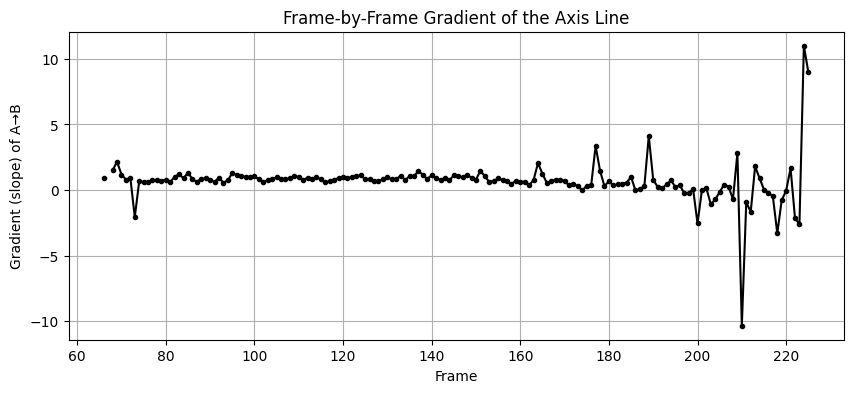

In [213]:
# Plot gradient vs frame
plt.figure(figsize=(10, 4))
plt.plot(df_spin['frame'], df_spin['gradient'], 'k.-')
plt.xlabel('Frame')
plt.ylabel('Gradient (slope) of A→B')
plt.title('Frame-by-Frame Gradient of the Axis Line')
plt.grid(True)
plt.show()

In [214]:
# 2) Compute gradient only on frames where both A and B exist
mask_valid = df_spin[['pA_x','pA_y','pB_x','pB_y']].notna().all(axis=1)
dx = df_spin['pB_x'] - df_spin['pA_x']
dy = df_spin['pB_y'] - df_spin['pA_y']
gradient = dy / dx.replace({0: np.nan})
gradient[~mask_valid] = np.nan

In [215]:
# --- sliding-window outlier removal ---
window_size = 11     # must be odd
mad_thresh  = 3.0    # e.g. 3×MAD

# 1) compute rolling median of gradient
rolling_med = df_spin['gradient'].rolling(window=window_size, center=True, min_periods=1).median()

# 2) compute rolling MAD: median of |x - median|
rolling_mad = (
    df_spin['gradient']
    .rolling(window=window_size, center=True, min_periods=1)
    .apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
)

# 3) identify outliers: |g - med| > thresh * MAD
is_outlier = np.abs(df_spin['gradient'] - rolling_med) > mad_thresh * rolling_mad

# 4) mask them out
df_spin['gradient_clean'] = df_spin['gradient'].mask(is_outlier)

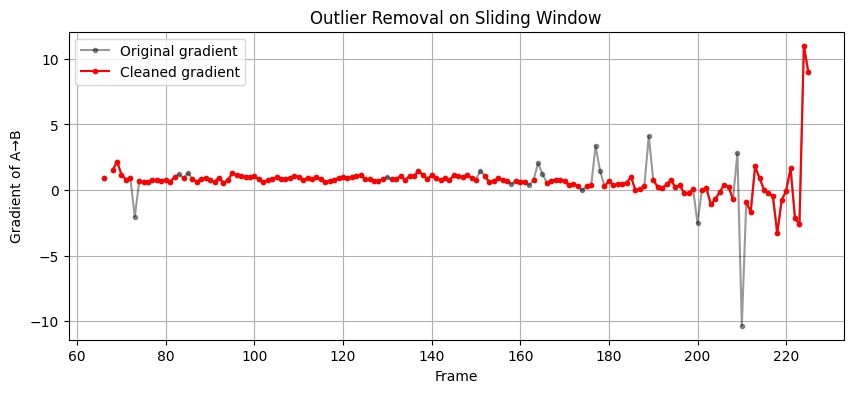

In [216]:
# --- visualize before/after ---
plt.figure(figsize=(10,4))
plt.plot(df_spin['frame'], df_spin['gradient'],      'k.-', alpha=0.4, label='Original gradient')
plt.plot(df_spin['frame'], df_spin['gradient_clean'],'r.-', label='Cleaned gradient')
plt.xlabel('Frame')
plt.ylabel('Gradient of A→B')
plt.title('Outlier Removal on Sliding Window')
plt.legend()
plt.grid(True)
plt.show()

In [217]:
# 3) Prepare data for fitting
x = df_spin.loc[mask_valid, 'frame'].values
y = gradient[mask_valid].values

# 4) Fit a spline (you can tweak s for smoothness; smaller s → tighter fit)
spline = UnivariateSpline(x, y, s=200)
x_fit = np.linspace(x.min(), x.max(), 500)
y_fit = spline(x_fit)

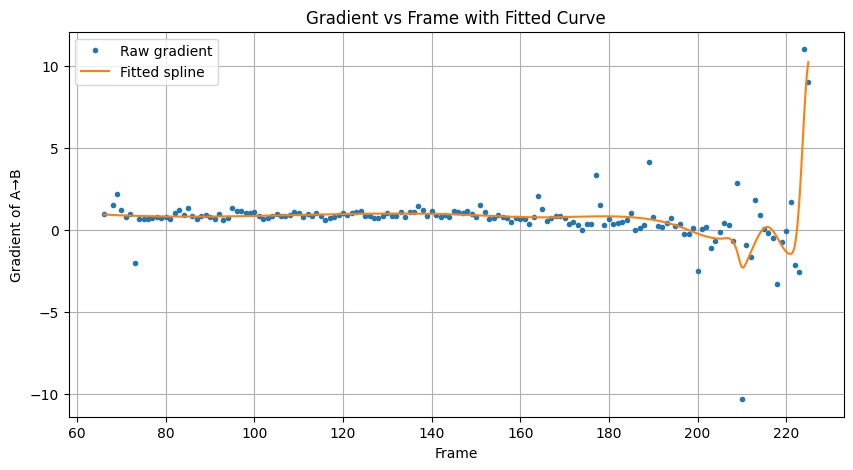

In [218]:
# 5) Plot raw vs. fitted curve
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='.', linestyle='None', label='Raw gradient')
plt.plot(x_fit, y_fit, label='Fitted spline')
plt.xlabel('Frame')
plt.ylabel('Gradient of A→B')
plt.title('Gradient vs Frame with Fitted Curve')
plt.grid(True)
plt.legend()
plt.show()

In [219]:
#OUTPUT_CSV_PATH = str(PROJECT_ROOT / "notebook" / "spin" / "intermediate_data" / f"Spin_data_processed_{VIDEO_NUMBER}.csv")
#df.to_csv(OUTPUT_CSV_PATH, index=False)